In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## DataLoading
load dataset from github or google drive

In [ ]:
from pathlib import Path

# Updated paths for Kaggle
base_path = Path("/kaggle/input/challenging-env-dataset")
training_path = base_path / "Train"
validate_path = base_path / "Validate"
testing_path = base_path / "Test"

print(training_path)
print(validate_path)
print(testing_path)


/kaggle/input/challenging-env-dataset/Train
/kaggle/input/challenging-env-dataset/Validate
/kaggle/input/challenging-env-dataset/Test


In [ ]:
#Loading From Collab
from pathlib import Path

training_path = Path("/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/train")
validate_path = Path("/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/validate")
testing_path = Path ("/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/test")

print(training_path)
print(validate_path)
print(testing_path)

/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/train
/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/validate
/content/drive/MyDrive/FYP Content/ C3ED – Challenging Environmental Conditions Crowd Estimation Dataset/test


In [ ]:
!pip install rarfile

In [ ]:
#loading data from github repo
import requests
import zipfile
import rarfile
from pathlib import Path
import os

# Setup path to data folder
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"
val_path =data_path / "validate"

# If the image folder doesn't exist, download it and prepare it...
if train_path.is_dir():
  print(f"Paths{train_path} Skipping Download")
else:
  # make sure to switch to content directory
  os.chdir("/content")
  print(f"Creating directory path {train_path} ")
  train_path.mkdir(parents=True, exist_ok=True)


#Download dataset
with open(data_path / "train.rar","wb") as f:
  request = requests.get("https://github.com/AhsanHussain12/FYP-DENSE-VISION/raw/main/train.rar")
  print("Downloading.... ")
  f.write(request.content)

#unzip train
with rarfile.RarFile(data_path/"train.rar", "r") as zip_ref:
  print("Extracting Zip File... ")
  zip_ref.extractall(train_path)

Creating directory path data/train 
Downloading.... 
Extracting Zip File... 


In [ ]:
print(train_path)

data


### Visualise Dataset

In [ ]:
# glob() just searches for files matching a pattern (wildcard * and file extensions) inside a folder.
# It returns a list of all matching file paths.

### Training Set ###

train_images = list(training_path.glob("image/*.jpg"))
train_images.sort()
train_density_maps = list(training_path.glob("density_map/*.h5"))
train_density_maps.sort()
print(f"Train Images: {len(train_images)} Train_Density_Maps: {len(train_density_maps)}")




Train Images: 1378 Train_Density_Maps: 1378


In [ ]:
### Validate Set ###

validate_images = list(validate_path.glob("image/*.jpg"))
validate_images.sort()
validate_density_maps = list(validate_path.glob("density_map/*.h5"))
validate_density_maps.sort()
print(f"Validate Images: {len(validate_images)} validate_Density_Maps: {len(validate_density_maps)}")

Validate Images: 295 validate_Density_Maps: 295


In [ ]:
### Test Set ###

test_images = list(testing_path.glob("image/*.jpg"))
test_images.sort()
test_density_maps = list(testing_path.glob("density_map/*.h5"))
test_density_maps.sort()
print(f"Test Images: {len(test_images)} Test_Density_Maps: {len(test_density_maps)}")

print(len(list(testing_path.glob("ground_truth/*.mat"))))

Test Images: 296 Test_Density_Maps: 296
296


In [ ]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import h5py

def visualize_image_density(image_paths, density_paths):

  idx = random.randint(1,len(image_paths))
  img = Image.open(image_paths[idx])
  img=np.array(img)

  with h5py.File(density_paths[idx],"r") as f:
    density_map = np.array(f["density"])

  print(img.shape)
  print(density_map.shape)

  # Create a side-by-side subplot
  plt.figure(figsize=(10, 5))

  plt.subplot(2, 1, 1)
  plt.imshow(img)
  plt.title(f'Image {train_images[idx]}')
  plt.axis('off')

  plt.subplot(2, 1, 2)
  plt.imshow(density_map, cmap="jet")
  plt.title(f'Density Map {train_density_maps[idx]}')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

(1080, 1920, 3)
(1080, 1920)


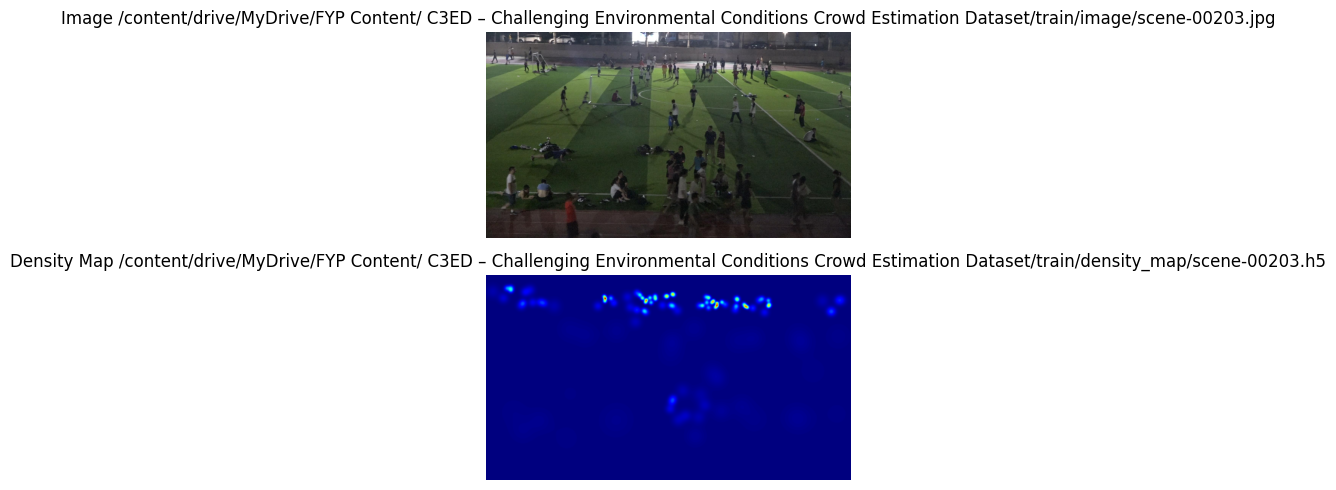

In [ ]:
visualize_image_density(validate_images,validate_density_maps)

(720, 1280, 3)
(720, 1280)


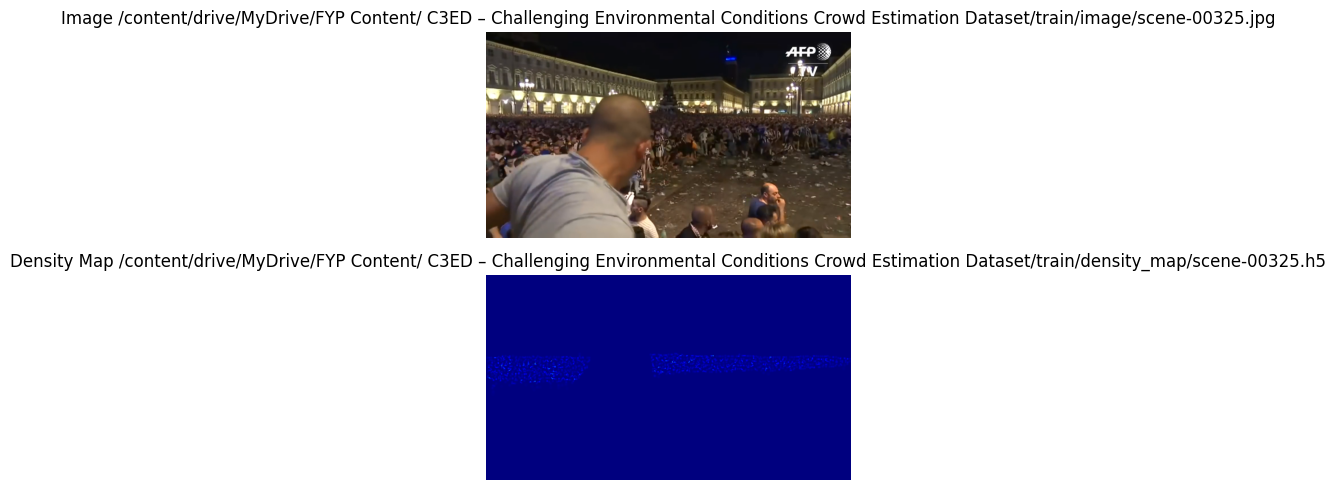

In [ ]:
visualize_image_density(test_images,test_density_maps)

(1080, 1920, 3)
(1080, 1920)


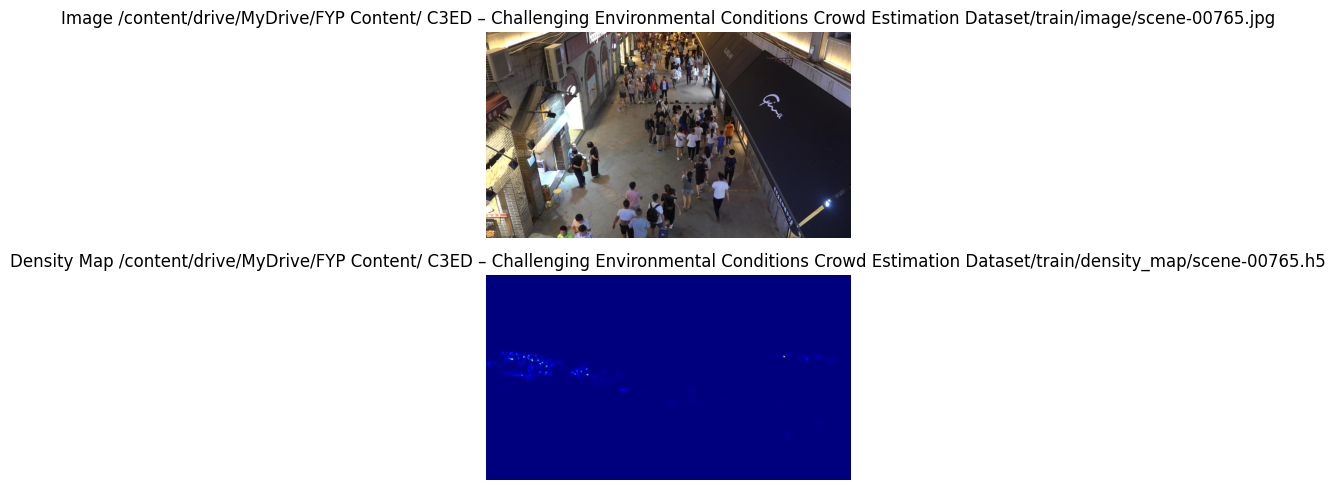

In [ ]:
visualize_image_density(train_images,train_density_maps)

### Custom Dataset Class

In [ ]:
from logging import root
import os
import random
import torch
import numpy as np
import h5py
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import cv2
from torchvision import transforms
import random

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
import random
import h5py
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms.functional as F

class CustomDataset(Dataset):
    def __init__(self, img_paths, augment=False, transform=None, shuffle=True, train=True):
        """
        Args:
            img_paths (list): List of image paths.
            augment (bool): Whether to apply data augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
            shuffle (bool): Whether to shuffle data (only meaningful during training).
            train (bool): Whether this dataset is for training or testing.
        """
        if shuffle and train:
            random.shuffle(img_paths)  # Shuffle the provided image paths during training only

        self.img_paths = img_paths
        self.augment = augment
        self.transform = transform
        self.train = train
        self.nSamples = len(img_paths)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img, target = self.load_data(img_path)

        # Apply augmentation only if train mode and augment flag is True
        if self.train and self.augment:
            img, target = self.random_augment(img, target)

        # Apply optional transforms (resize, normalize etc.)
        if self.transform:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)  # Default: simple to_tensor

        target = self.resize_density(target)  # Always resize density map

        target = torch.tensor(target, dtype=torch.float32)

        return img, target

    def load_data(self, img_path):
        img_path = str(img_path) # Ensure img_path is a string for safe replacement
        gt_path = img_path.replace('.jpg', '.h5').replace('image', 'density_map')

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Load density map
        with h5py.File(gt_path, 'r') as gt_file:
            target = np.asarray(gt_file['density'])

        return img, target

    def random_augment(self, img, target):
        """
        Applies random crop and horizontal flip.
        """
        # Random crop to half size
        crop_w, crop_h = img.size[0] // 2, img.size[1] // 2
        if img.size[0] > crop_w and img.size[1] > crop_h:
            dx = random.randint(0, img.size[0] - crop_w)
            dy = random.randint(0, img.size[1] - crop_h)

            img = img.crop((dx, dy, dx + crop_w, dy + crop_h))
            target = target[dy:dy + crop_h, dx:dx + crop_w]

        # Random horizontal flip
        if random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            target = np.fliplr(target)

        return img, target

    def resize_density(self, target):
        """
        Resize density map while preserving the total sum.
        """
        h, w = target.shape
        new_h, new_w = h // 8, w // 8
        target_resized = cv2.resize(target, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # scale to preserve the total count (density sum)
        scale = (h * w) / (new_h * new_w)
        target = target_resized * scale
        return target


## Model

In [ ]:
import torch
from torch import  nn
from torchvision import models


class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()

            frontend_dict = list(self.frontend.state_dict().items())
            mod_dict = list(mod.state_dict().items())
            # print(frontend_dict,mod_dict)
            for i in range(len(frontend_dict)):
                frontend_dict[i][1].data[:] = mod_dict[i][1].data[:]

    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)



## Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
import sys
import os
import warnings
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torch.utils.data import DataLoader


### Training/Fine-Tuning Loop

In [ ]:
!pip install tqdm


### Training Function

In [ ]:
from torch.nn.utils import clip_grad_norm_

def train(train_loader, epoch):
    model.train()
    running_loss = 0.0

    # Freeze BatchNorm layers when using batch_size=1
    for m in model.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()

    for i, (img, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)):
        # Move to device
        img    = img.to(device)
        target = target.float().unsqueeze(1).to(device)

        # Forward
        pred = model(img)

        # NaN checks
        if torch.isnan(pred).any():
            tqdm.write(f"⚠️  NaN detected in predictions at batch {i+1}")
            break

        loss = loss_fn(pred, target)

        if torch.isnan(loss):
            tqdm.write(f"⚠️  NaN detected in loss at batch {i+1}")
            break

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=5.0)  # optional, prevent explosions
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            avg_batch_loss = running_loss / (i + 1)
            tqdm.write(f"  Batch {i+1}/{len(train_loader)} – Avg Loss: {avg_batch_loss:.4f}")

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} Training Loss: {epoch_loss:.4f}")



### Validation Function

In [ ]:
def validate(val_loader):
    model.eval()
    mae = 0.0

    with torch.no_grad():
        for i, (img, target) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
            img = img.to(device)
            target = target.float().unsqueeze(1).to(device)

            pred = model(img)
            mae += torch.abs(pred.data.sum() - target.sum()).item()

    mae = mae / len(val_loader)
    print(f" * MAE {mae:.3f}")
    scheduler.step(mae)

    return mae


### Resuming Model From a Checkpoint

### Load top_checkpoints HyperParam

In [ ]:
from pathlib import Path

def get_top_checkpoints():

  top_checkpoints = []

  base_path = Path("/content/drive/MyDrive/FYP Content/checkpoints/")
  checkpoint_paths = list(base_path.glob("C3ED_MAE_*.pth.tar"))
  for checkpoint_path in checkpoint_paths:
    checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
    top_checkpoints.append((checkpoint['best_prec1'],checkpoint_path))


  return top_checkpoints


In [ ]:
checkpoint_path = "/content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_47.01_epoch_65.pth.tar"
# checkpoint_path = "/content/drive/MyDrive/FYP Content/checkpoints/partAmodel_best MAE=66.pth.tar"


best_checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

print(best_checkpoint.keys())  # Check contents

dict_keys(['epoch', 'arch', 'state_dict', 'best_prec1', 'optimizer'])


### Hyperparameters

In [ ]:
### Hyper Parameters ###
# Learning Rate
# epochs
# momentum
# weight_decay
# batch_size
# start_epoch (load from checkpoint if any)
# patience (tolerance window)
# top_k (top checkpoint counts)
# top_checkpoints [] (restore from checkpoints if any)

Lr =  1e-3
Epochs = 100
Momentum = 0.95
W_decay = 5*1e-4
Batch_size = 1
Start_epoch = best_checkpoint['epoch'] if best_checkpoint else 0
patience = 5
top_k = 5

ckpts = get_top_checkpoints()
top_checkpoints = ckpts if len(ckpts) == 5 else []

print(Start_epoch)
print(top_checkpoints)


65
[]


In [ ]:
# #Instantiating the model

model = CSRNet()
model = model.to(device)

# Setting up the loss function
loss_fn = nn.MSELoss(size_average=False).to(device)

#Setting up the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=Lr,momentum=Momentum,weight_decay=W_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
#learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 181MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr

In [ ]:
print(model)

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
model.load_state_dict(best_checkpoint['state_dict'])
# optimizer.load_state_dict(best_checkpoint['optimizer'])


print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.95
    nesterov: False
    weight_decay: 0.0005
)


### Fine-Tune Loop

In [ ]:
from torch.utils.data import DataLoader
import torch
import os
from tqdm import tqdm


#on-collab
checkpoint_dir = "/content/drive/MyDrive/FYP Content/checkpoints/"


train_dataset = CustomDataset(
    train_images,
    augment=True,
    train=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)


val_dataset = CustomDataset(
    validate_images,
    augment=False,
    train=False,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)



# ----- Configurable Parameters -----

patience = 10
top_k = 3

# ----- State Tracking -----
no_improvement_epochs = 0
val_mae_history = [] # used for early stopping logic


# since the models density maps are all over the place freezin the frontend to focus on backend responsible for density maps
for param in model.frontend.parameters():
    param.requires_grad = False


for epoch in range(Start_epoch, Epochs):
    print(f"\nEpoch {epoch+1}/{Epochs}")

    train(train_loader, epoch)
    val_loss = validate(val_loader)

    # Early stopping logic
    if len(val_mae_history) > 0 and val_loss > val_mae_history[-1]:
        no_improvement_epochs += 1
        print(f"No improvement. Early stopping counter: {no_improvement_epochs}/{patience}")
    else:
        no_improvement_epochs = 0

    val_mae_history.append(val_loss)


    if no_improvement_epochs >= patience:
        print(f"⛔ Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
        break

    # --------- Top-K Checkpointing Logic ---------
    checkpoint_path = os.path.join(
        checkpoint_dir, f'C3ED_MAE_{val_loss:.2f}_epoch_{epoch+1}.pth.tar'
    )

    if len(top_checkpoints) < top_k:
        # Less than K: save unconditionally
        torch.save({
            'epoch': epoch + 1,
            'arch': "CSRnet",
            'state_dict': model.state_dict(),
            'best_prec1': val_loss,
            'optimizer': optimizer.state_dict(),
        }, checkpoint_path)
        top_checkpoints.append((val_loss, checkpoint_path))
        top_checkpoints.sort()
        print(f"✅ Checkpoint saved in top-{top_k} at {checkpoint_path}")

    elif val_loss < top_checkpoints[-1][0]:  # Better than worst
        torch.save({
            'epoch': epoch + 1,
            'arch': "CSRnet",
            'state_dict': model.state_dict(),
            'best_prec1': val_loss,
            'optimizer': optimizer.state_dict(),
        }, checkpoint_path)

        # Remove the worst
        worst_loss, worst_path = top_checkpoints[-1]
        try:
            os.remove(worst_path)
            print(f"🗑️ Removed worst checkpoint: {worst_path}")
        except Exception as e:
            print(f"⚠️ Could not delete old checkpoint: {e}")

        # Add new one and sort
        top_checkpoints[-1] = (val_loss, checkpoint_path)
        top_checkpoints.sort()
        print(f"✅ Checkpoint replaced and sorted in top-{top_k}")
    else:
        print("⚠️ Validation loss not in top-K, checkpoint not saved.")



Epoch 66/100


Epoch 65 Training:   8%|▊         | 107/1378 [00:02<00:28, 44.21it/s]

  Batch 100/1378 – Avg Loss: 37.2481


Epoch 65 Training:  15%|█▍        | 206/1378 [00:04<00:25, 46.55it/s]

  Batch 200/1378 – Avg Loss: 34.7995


Epoch 65 Training:  22%|██▏       | 309/1378 [00:06<00:22, 48.11it/s]

  Batch 300/1378 – Avg Loss: 46.0884


Epoch 65 Training:  30%|██▉       | 407/1378 [00:08<00:21, 45.33it/s]

  Batch 400/1378 – Avg Loss: 51.6025


Epoch 65 Training:  37%|███▋      | 509/1378 [00:11<00:18, 47.25it/s]

  Batch 500/1378 – Avg Loss: 47.9467


Epoch 65 Training:  44%|████▍     | 607/1378 [00:13<00:16, 47.51it/s]

  Batch 600/1378 – Avg Loss: 42.6649


Epoch 65 Training:  51%|█████▏    | 708/1378 [00:15<00:15, 44.43it/s]

  Batch 700/1378 – Avg Loss: 58.6749


Epoch 65 Training:  58%|█████▊    | 806/1378 [00:17<00:14, 40.18it/s]

  Batch 800/1378 – Avg Loss: 69.9366


Epoch 65 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 44.44it/s]

  Batch 900/1378 – Avg Loss: 70.6276


Epoch 65 Training:  73%|███████▎  | 1005/1378 [00:22<00:08, 45.14it/s]

  Batch 1000/1378 – Avg Loss: 68.0128


Epoch 65 Training:  80%|████████  | 1109/1378 [00:24<00:05, 48.41it/s]

  Batch 1100/1378 – Avg Loss: 68.2922


Epoch 65 Training:  88%|████████▊ | 1206/1378 [00:26<00:03, 45.91it/s]

  Batch 1200/1378 – Avg Loss: 72.2331


Epoch 65 Training:  95%|█████████▍| 1309/1378 [00:28<00:01, 45.94it/s]

  Batch 1300/1378 – Avg Loss: 72.6319


Epoch 65 Training Loss: 70.0046


 * MAE 413.012
✅ Checkpoint saved in top-3 at /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_413.01_epoch_66.pth.tar

Epoch 67/100


Epoch 66 Training:   8%|▊         | 106/1378 [00:02<00:28, 44.04it/s]

  Batch 100/1378 – Avg Loss: 70.0505


Epoch 66 Training:  15%|█▌        | 208/1378 [00:04<00:25, 45.13it/s]

  Batch 200/1378 – Avg Loss: 43.5133


Epoch 66 Training:  22%|██▏       | 305/1378 [00:06<00:23, 45.89it/s]

  Batch 300/1378 – Avg Loss: 47.4574


Epoch 66 Training:  30%|██▉       | 407/1378 [00:09<00:20, 47.64it/s]

  Batch 400/1378 – Avg Loss: 45.9449


Epoch 66 Training:  37%|███▋      | 504/1378 [00:11<00:19, 45.82it/s]

  Batch 500/1378 – Avg Loss: 46.2254


Epoch 66 Training:  44%|████▍     | 606/1378 [00:13<00:16, 46.61it/s]

  Batch 600/1378 – Avg Loss: 58.6674


Epoch 66 Training:  51%|█████     | 706/1378 [00:15<00:14, 46.47it/s]

  Batch 700/1378 – Avg Loss: 76.5411


Epoch 66 Training:  58%|█████▊    | 806/1378 [00:17<00:12, 45.21it/s]

  Batch 800/1378 – Avg Loss: 75.4135


Epoch 66 Training:  66%|██████▌   | 908/1378 [00:20<00:11, 42.38it/s]

  Batch 900/1378 – Avg Loss: 76.1401


Epoch 66 Training:  73%|███████▎  | 1006/1378 [00:22<00:08, 44.12it/s]

  Batch 1000/1378 – Avg Loss: 78.0583


Epoch 66 Training:  80%|████████  | 1104/1378 [00:24<00:06, 44.05it/s]

  Batch 1100/1378 – Avg Loss: 79.2635


Epoch 66 Training:  88%|████████▊ | 1207/1378 [00:26<00:03, 44.86it/s]

  Batch 1200/1378 – Avg Loss: 80.1983


Epoch 66 Training:  95%|█████████▍| 1309/1378 [00:28<00:01, 47.02it/s]

  Batch 1300/1378 – Avg Loss: 79.0601


Epoch 66 Training Loss: 75.8668


 * MAE 836.782
No improvement. Early stopping counter: 1/10
✅ Checkpoint saved in top-3 at /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_836.78_epoch_67.pth.tar

Epoch 68/100


Epoch 67 Training:   8%|▊         | 107/1378 [00:02<00:29, 43.69it/s]

  Batch 100/1378 – Avg Loss: 39.7860


Epoch 67 Training:  15%|█▍        | 204/1378 [00:04<00:24, 47.45it/s]

  Batch 200/1378 – Avg Loss: 32.0334


Epoch 67 Training:  22%|██▏       | 305/1378 [00:06<00:22, 46.70it/s]

  Batch 300/1378 – Avg Loss: 32.3192


Epoch 67 Training:  30%|██▉       | 409/1378 [00:09<00:21, 45.71it/s]

  Batch 400/1378 – Avg Loss: 46.3944


Epoch 67 Training:  37%|███▋      | 507/1378 [00:11<00:19, 45.23it/s]

  Batch 500/1378 – Avg Loss: 42.3018


Epoch 67 Training:  44%|████▍     | 605/1378 [00:13<00:16, 48.10it/s]

  Batch 600/1378 – Avg Loss: 40.4818


Epoch 67 Training:  51%|█████     | 705/1378 [00:15<00:14, 47.49it/s]

  Batch 700/1378 – Avg Loss: 46.5718


Epoch 67 Training:  59%|█████▊    | 807/1378 [00:17<00:11, 50.20it/s]

  Batch 800/1378 – Avg Loss: 50.0684


Epoch 67 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 45.74it/s]

  Batch 900/1378 – Avg Loss: 49.5948


Epoch 67 Training:  73%|███████▎  | 1004/1378 [00:21<00:08, 45.99it/s]

  Batch 1000/1378 – Avg Loss: 55.5154


Epoch 67 Training:  80%|████████  | 1106/1378 [00:24<00:05, 46.99it/s]

  Batch 1100/1378 – Avg Loss: 60.9159


Epoch 67 Training:  88%|████████▊ | 1207/1378 [00:26<00:03, 46.56it/s]

  Batch 1200/1378 – Avg Loss: 65.9564


Epoch 67 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 47.76it/s]

  Batch 1300/1378 – Avg Loss: 65.4324


Epoch 67 Training Loss: 64.0397


 * MAE 342.636
✅ Checkpoint saved in top-3 at /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_342.64_epoch_68.pth.tar

Epoch 69/100


Epoch 68 Training:   8%|▊         | 106/1378 [00:02<00:28, 44.67it/s]

  Batch 100/1378 – Avg Loss: 24.3544


Epoch 68 Training:  15%|█▌        | 207/1378 [00:04<00:24, 47.48it/s]

  Batch 200/1378 – Avg Loss: 22.5008


Epoch 68 Training:  22%|██▏       | 308/1378 [00:06<00:23, 45.93it/s]

  Batch 300/1378 – Avg Loss: 59.2827


Epoch 68 Training:  30%|██▉       | 408/1378 [00:09<00:22, 43.05it/s]

  Batch 400/1378 – Avg Loss: 51.3961


Epoch 68 Training:  37%|███▋      | 506/1378 [00:11<00:20, 42.92it/s]

  Batch 500/1378 – Avg Loss: 57.3514


Epoch 68 Training:  44%|████▍     | 607/1378 [00:13<00:16, 46.52it/s]

  Batch 600/1378 – Avg Loss: 62.8638


Epoch 68 Training:  52%|█████▏    | 710/1378 [00:15<00:13, 48.17it/s]

  Batch 700/1378 – Avg Loss: 58.7789


Epoch 68 Training:  59%|█████▊    | 807/1378 [00:17<00:12, 46.54it/s]

  Batch 800/1378 – Avg Loss: 65.9569


Epoch 68 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 43.40it/s]

  Batch 900/1378 – Avg Loss: 82.5338


Epoch 68 Training:  73%|███████▎  | 1006/1378 [00:21<00:07, 48.08it/s]

  Batch 1000/1378 – Avg Loss: 77.9814


Epoch 68 Training:  81%|████████  | 1110/1378 [00:24<00:05, 48.08it/s]

  Batch 1100/1378 – Avg Loss: 73.7072


Epoch 68 Training:  88%|████████▊ | 1207/1378 [00:26<00:03, 45.40it/s]

  Batch 1200/1378 – Avg Loss: 76.8056


Epoch 68 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 47.49it/s]

  Batch 1300/1378 – Avg Loss: 76.9566


Epoch 68 Training Loss: 73.4296


 * MAE 346.581
No improvement. Early stopping counter: 1/10
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_836.78_epoch_67.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 70/100


Epoch 69 Training:   8%|▊         | 109/1378 [00:02<00:25, 48.87it/s]

  Batch 100/1378 – Avg Loss: 72.3288


Epoch 69 Training:  15%|█▍        | 204/1378 [00:04<00:24, 47.14it/s]

  Batch 200/1378 – Avg Loss: 135.1182


Epoch 69 Training:  22%|██▏       | 308/1378 [00:06<00:22, 47.32it/s]

  Batch 300/1378 – Avg Loss: 104.7822


Epoch 69 Training:  29%|██▉       | 405/1378 [00:08<00:21, 45.52it/s]

  Batch 400/1378 – Avg Loss: 105.5485


Epoch 69 Training:  37%|███▋      | 505/1378 [00:10<00:19, 44.36it/s]

  Batch 500/1378 – Avg Loss: 115.3884


Epoch 69 Training:  44%|████▍     | 606/1378 [00:13<00:16, 46.73it/s]

  Batch 600/1378 – Avg Loss: 101.1490


Epoch 69 Training:  51%|█████     | 705/1378 [00:15<00:14, 46.60it/s]

  Batch 700/1378 – Avg Loss: 91.1096


Epoch 69 Training:  58%|█████▊    | 804/1378 [00:17<00:12, 46.23it/s]

  Batch 800/1378 – Avg Loss: 85.4768


Epoch 69 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 45.76it/s]

  Batch 900/1378 – Avg Loss: 78.1291


Epoch 69 Training:  73%|███████▎  | 1007/1378 [00:21<00:08, 42.87it/s]

  Batch 1000/1378 – Avg Loss: 72.4597


Epoch 69 Training:  80%|████████  | 1105/1378 [00:23<00:05, 46.93it/s]

  Batch 1100/1378 – Avg Loss: 69.7036


Epoch 69 Training:  88%|████████▊ | 1210/1378 [00:26<00:03, 49.38it/s]

  Batch 1200/1378 – Avg Loss: 65.4894


Epoch 69 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 44.80it/s]

  Batch 1300/1378 – Avg Loss: 62.0954


Epoch 69 Training Loss: 62.2836


 * MAE 213.062
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_413.01_epoch_66.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 71/100


Epoch 70 Training:   8%|▊         | 105/1378 [00:02<00:30, 42.40it/s]

  Batch 100/1378 – Avg Loss: 25.3212


Epoch 70 Training:  15%|█▍        | 204/1378 [00:04<00:24, 47.64it/s]

  Batch 200/1378 – Avg Loss: 76.3174


Epoch 70 Training:  22%|██▏       | 306/1378 [00:06<00:21, 49.52it/s]

  Batch 300/1378 – Avg Loss: 125.5865


Epoch 70 Training:  29%|██▉       | 404/1378 [00:08<00:20, 47.65it/s]

  Batch 400/1378 – Avg Loss: 102.3568


Epoch 70 Training:  37%|███▋      | 508/1378 [00:11<00:19, 44.66it/s]

  Batch 500/1378 – Avg Loss: 94.1189


Epoch 70 Training:  44%|████▍     | 608/1378 [00:13<00:17, 44.04it/s]

  Batch 600/1378 – Avg Loss: 81.6652


Epoch 70 Training:  51%|█████     | 704/1378 [00:15<00:15, 43.61it/s]

  Batch 700/1378 – Avg Loss: 74.4718


Epoch 70 Training:  59%|█████▊    | 807/1378 [00:17<00:12, 45.64it/s]

  Batch 800/1378 – Avg Loss: 68.1813


Epoch 70 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 44.84it/s]

  Batch 900/1378 – Avg Loss: 72.8414


Epoch 70 Training:  73%|███████▎  | 1008/1378 [00:22<00:07, 48.42it/s]

  Batch 1000/1378 – Avg Loss: 73.5063


Epoch 70 Training:  80%|████████  | 1107/1378 [00:24<00:05, 45.36it/s]

  Batch 1100/1378 – Avg Loss: 76.6709


Epoch 70 Training:  88%|████████▊ | 1208/1378 [00:26<00:03, 44.99it/s]

  Batch 1200/1378 – Avg Loss: 73.8655


Epoch 70 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 45.48it/s]

  Batch 1300/1378 – Avg Loss: 73.0894


Epoch 70 Training Loss: 72.3003


 * MAE 367.776
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 72/100


Epoch 71 Training:   8%|▊         | 109/1378 [00:02<00:28, 44.98it/s]

  Batch 100/1378 – Avg Loss: 37.2246


Epoch 71 Training:  15%|█▍        | 206/1378 [00:04<00:24, 48.28it/s]

  Batch 200/1378 – Avg Loss: 51.5310


Epoch 71 Training:  22%|██▏       | 305/1378 [00:06<00:23, 45.95it/s]

  Batch 300/1378 – Avg Loss: 46.9762


Epoch 71 Training:  29%|██▉       | 406/1378 [00:08<00:20, 46.33it/s]

  Batch 400/1378 – Avg Loss: 45.3042


Epoch 71 Training:  37%|███▋      | 509/1378 [00:11<00:18, 47.53it/s]

  Batch 500/1378 – Avg Loss: 51.6489


Epoch 71 Training:  44%|████▍     | 605/1378 [00:13<00:16, 48.26it/s]

  Batch 600/1378 – Avg Loss: 58.6589


Epoch 71 Training:  51%|█████     | 705/1378 [00:15<00:14, 46.67it/s]

  Batch 700/1378 – Avg Loss: 55.8455


Epoch 71 Training:  59%|█████▊    | 809/1378 [00:17<00:11, 47.77it/s]

  Batch 800/1378 – Avg Loss: 74.8580


Epoch 71 Training:  66%|██████▌   | 904/1378 [00:19<00:10, 45.15it/s]

  Batch 900/1378 – Avg Loss: 72.8834


Epoch 71 Training:  73%|███████▎  | 1005/1378 [00:21<00:08, 44.36it/s]

  Batch 1000/1378 – Avg Loss: 69.5936


Epoch 71 Training:  80%|████████  | 1105/1378 [00:23<00:06, 44.21it/s]

  Batch 1100/1378 – Avg Loss: 66.6200


Epoch 71 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 47.00it/s]

  Batch 1200/1378 – Avg Loss: 63.9800


Epoch 71 Training:  95%|█████████▍| 1308/1378 [00:28<00:01, 47.69it/s]

  Batch 1300/1378 – Avg Loss: 67.8858


Epoch 71 Training Loss: 68.8850


 * MAE 491.278
No improvement. Early stopping counter: 2/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 73/100


Epoch 72 Training:   8%|▊         | 107/1378 [00:02<00:27, 46.77it/s]

  Batch 100/1378 – Avg Loss: 94.0944


Epoch 72 Training:  15%|█▍        | 206/1378 [00:04<00:26, 43.97it/s]

  Batch 200/1378 – Avg Loss: 61.1940


Epoch 72 Training:  22%|██▏       | 306/1378 [00:06<00:21, 49.16it/s]

  Batch 300/1378 – Avg Loss: 63.3542


Epoch 72 Training:  30%|██▉       | 407/1378 [00:08<00:20, 47.26it/s]

  Batch 400/1378 – Avg Loss: 82.8534


Epoch 72 Training:  37%|███▋      | 506/1378 [00:11<00:17, 48.50it/s]

  Batch 500/1378 – Avg Loss: 71.2882


Epoch 72 Training:  44%|████▍     | 606/1378 [00:13<00:17, 43.37it/s]

  Batch 600/1378 – Avg Loss: 78.7705


Epoch 72 Training:  51%|█████     | 706/1378 [00:15<00:14, 45.95it/s]

  Batch 700/1378 – Avg Loss: 83.2773


Epoch 72 Training:  58%|█████▊    | 805/1378 [00:17<00:12, 46.61it/s]

  Batch 800/1378 – Avg Loss: 79.8556


Epoch 72 Training:  66%|██████▌   | 907/1378 [00:19<00:09, 50.38it/s]

  Batch 900/1378 – Avg Loss: 80.4691


Epoch 72 Training:  73%|███████▎  | 1004/1378 [00:21<00:07, 48.08it/s]

  Batch 1000/1378 – Avg Loss: 74.9801


Epoch 72 Training:  81%|████████  | 1110/1378 [00:23<00:05, 49.64it/s]

  Batch 1100/1378 – Avg Loss: 71.3906


Epoch 72 Training:  88%|████████▊ | 1206/1378 [00:26<00:03, 48.54it/s]

  Batch 1200/1378 – Avg Loss: 69.5675


Epoch 72 Training:  95%|█████████▍| 1308/1378 [00:28<00:01, 46.21it/s]

  Batch 1300/1378 – Avg Loss: 68.0149


Epoch 72 Training Loss: 67.2926


 * MAE 1051.634
No improvement. Early stopping counter: 3/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 74/100


Epoch 73 Training:   8%|▊         | 106/1378 [00:02<00:27, 45.84it/s]

  Batch 100/1378 – Avg Loss: 34.9254


Epoch 73 Training:  15%|█▌        | 208/1378 [00:04<00:23, 49.71it/s]

  Batch 200/1378 – Avg Loss: 49.9533


Epoch 73 Training:  22%|██▏       | 305/1378 [00:06<00:23, 46.22it/s]

  Batch 300/1378 – Avg Loss: 55.8712


Epoch 73 Training:  30%|██▉       | 408/1378 [00:08<00:21, 45.42it/s]

  Batch 400/1378 – Avg Loss: 59.2094


Epoch 73 Training:  37%|███▋      | 505/1378 [00:11<00:18, 48.21it/s]

  Batch 500/1378 – Avg Loss: 69.6133


Epoch 73 Training:  44%|████▍     | 606/1378 [00:13<00:17, 43.44it/s]

  Batch 600/1378 – Avg Loss: 73.7880


Epoch 73 Training:  51%|█████     | 706/1378 [00:15<00:13, 48.69it/s]

  Batch 700/1378 – Avg Loss: 69.1222


Epoch 73 Training:  58%|█████▊    | 806/1378 [00:17<00:11, 49.97it/s]

  Batch 800/1378 – Avg Loss: 66.2711


Epoch 73 Training:  66%|██████▌   | 908/1378 [00:19<00:09, 48.89it/s]

  Batch 900/1378 – Avg Loss: 67.2397


Epoch 73 Training:  73%|███████▎  | 1006/1378 [00:21<00:07, 46.96it/s]

  Batch 1000/1378 – Avg Loss: 63.2234


Epoch 73 Training:  80%|████████  | 1106/1378 [00:23<00:05, 47.18it/s]

  Batch 1100/1378 – Avg Loss: 61.5339


Epoch 73 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 47.37it/s]

  Batch 1200/1378 – Avg Loss: 59.1530


Epoch 73 Training:  95%|█████████▍| 1309/1378 [00:28<00:01, 48.47it/s]

  Batch 1300/1378 – Avg Loss: 61.1287


Epoch 73 Training Loss: 60.0118


 * MAE 530.381
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 75/100


Epoch 74 Training:   8%|▊         | 105/1378 [00:02<00:29, 43.62it/s]

  Batch 100/1378 – Avg Loss: 55.0250


Epoch 74 Training:  15%|█▌        | 207/1378 [00:04<00:24, 47.09it/s]

  Batch 200/1378 – Avg Loss: 53.2753


Epoch 74 Training:  22%|██▏       | 306/1378 [00:06<00:21, 49.10it/s]

  Batch 300/1378 – Avg Loss: 51.3029


Epoch 74 Training:  30%|██▉       | 409/1378 [00:08<00:21, 45.77it/s]

  Batch 400/1378 – Avg Loss: 88.5215


Epoch 74 Training:  37%|███▋      | 505/1378 [00:11<00:18, 46.80it/s]

  Batch 500/1378 – Avg Loss: 76.6227


Epoch 74 Training:  44%|████▍     | 607/1378 [00:13<00:15, 48.22it/s]

  Batch 600/1378 – Avg Loss: 66.1225


Epoch 74 Training:  51%|█████▏    | 709/1378 [00:15<00:14, 47.38it/s]

  Batch 700/1378 – Avg Loss: 69.0339


Epoch 74 Training:  58%|█████▊    | 806/1378 [00:17<00:12, 44.09it/s]

  Batch 800/1378 – Avg Loss: 74.6097


Epoch 74 Training:  66%|██████▌   | 908/1378 [00:19<00:09, 47.15it/s]

  Batch 900/1378 – Avg Loss: 71.3137


Epoch 74 Training:  73%|███████▎  | 1007/1378 [00:21<00:08, 46.04it/s]

  Batch 1000/1378 – Avg Loss: 68.3394


Epoch 74 Training:  80%|████████  | 1105/1378 [00:23<00:05, 50.40it/s]

  Batch 1100/1378 – Avg Loss: 65.8104


Epoch 74 Training:  88%|████████▊ | 1207/1378 [00:25<00:03, 45.72it/s]

  Batch 1200/1378 – Avg Loss: 62.1024


Epoch 74 Training:  95%|█████████▍| 1309/1378 [00:27<00:01, 48.10it/s]

  Batch 1300/1378 – Avg Loss: 61.8362


Epoch 74 Training Loss: 61.5219


 * MAE 429.569
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 76/100


Epoch 75 Training:   8%|▊         | 110/1378 [00:02<00:25, 50.52it/s]

  Batch 100/1378 – Avg Loss: 28.2588


Epoch 75 Training:  15%|█▍        | 206/1378 [00:04<00:26, 43.89it/s]

  Batch 200/1378 – Avg Loss: 41.5240


Epoch 75 Training:  22%|██▏       | 308/1378 [00:06<00:24, 43.01it/s]

  Batch 300/1378 – Avg Loss: 63.8441


Epoch 75 Training:  30%|██▉       | 407/1378 [00:08<00:20, 47.85it/s]

  Batch 400/1378 – Avg Loss: 51.5850


Epoch 75 Training:  37%|███▋      | 505/1378 [00:11<00:18, 47.89it/s]

  Batch 500/1378 – Avg Loss: 48.9730


Epoch 75 Training:  44%|████▍     | 604/1378 [00:13<00:15, 49.46it/s]

  Batch 600/1378 – Avg Loss: 49.8563


Epoch 75 Training:  51%|█████▏    | 707/1378 [00:15<00:14, 47.43it/s]

  Batch 700/1378 – Avg Loss: 45.7079


Epoch 75 Training:  59%|█████▊    | 809/1378 [00:17<00:12, 46.98it/s]

  Batch 800/1378 – Avg Loss: 42.5120


Epoch 75 Training:  66%|██████▌   | 909/1378 [00:19<00:09, 47.07it/s]

  Batch 900/1378 – Avg Loss: 44.3269


Epoch 75 Training:  73%|███████▎  | 1007/1378 [00:21<00:07, 47.13it/s]

  Batch 1000/1378 – Avg Loss: 44.7905


Epoch 75 Training:  80%|████████  | 1108/1378 [00:23<00:05, 46.22it/s]

  Batch 1100/1378 – Avg Loss: 47.5417


Epoch 75 Training:  87%|████████▋ | 1204/1378 [00:25<00:03, 46.47it/s]

  Batch 1200/1378 – Avg Loss: 57.2547


Epoch 75 Training:  95%|█████████▍| 1308/1378 [00:27<00:01, 48.87it/s]

  Batch 1300/1378 – Avg Loss: 61.9582


Epoch 75 Training Loss: 62.0240


 * MAE 60.062
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_346.58_epoch_69.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 77/100


Epoch 76 Training:   8%|▊         | 106/1378 [00:02<00:27, 46.41it/s]

  Batch 100/1378 – Avg Loss: 39.0981


Epoch 76 Training:  15%|█▌        | 207/1378 [00:04<00:26, 44.79it/s]

  Batch 200/1378 – Avg Loss: 71.7844


Epoch 76 Training:  22%|██▏       | 305/1378 [00:06<00:22, 48.50it/s]

  Batch 300/1378 – Avg Loss: 86.2930


Epoch 76 Training:  29%|██▉       | 406/1378 [00:08<00:20, 46.49it/s]

  Batch 400/1378 – Avg Loss: 72.4218


Epoch 76 Training:  37%|███▋      | 508/1378 [00:11<00:19, 44.56it/s]

  Batch 500/1378 – Avg Loss: 61.4184


Epoch 76 Training:  44%|████▍     | 610/1378 [00:13<00:15, 50.11it/s]

  Batch 600/1378 – Avg Loss: 53.7080


Epoch 76 Training:  51%|█████▏    | 708/1378 [00:15<00:14, 45.23it/s]

  Batch 700/1378 – Avg Loss: 55.7472


Epoch 76 Training:  58%|█████▊    | 804/1378 [00:17<00:12, 46.51it/s]

  Batch 800/1378 – Avg Loss: 60.3028


Epoch 76 Training:  66%|██████▌   | 906/1378 [00:19<00:09, 48.48it/s]

  Batch 900/1378 – Avg Loss: 56.4605


Epoch 76 Training:  73%|███████▎  | 1009/1378 [00:21<00:07, 46.67it/s]

  Batch 1000/1378 – Avg Loss: 59.9973


Epoch 76 Training:  80%|████████  | 1106/1378 [00:23<00:06, 42.97it/s]

  Batch 1100/1378 – Avg Loss: 59.9329


Epoch 76 Training:  88%|████████▊ | 1209/1378 [00:26<00:03, 47.38it/s]

  Batch 1200/1378 – Avg Loss: 62.7126


Epoch 76 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 45.33it/s]

  Batch 1300/1378 – Avg Loss: 59.5653


Epoch 76 Training Loss: 59.1981


 * MAE 654.683
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 78/100


Epoch 77 Training:   8%|▊         | 105/1378 [00:02<00:27, 45.65it/s]

  Batch 100/1378 – Avg Loss: 64.9968


Epoch 77 Training:  15%|█▌        | 209/1378 [00:04<00:23, 49.00it/s]

  Batch 200/1378 – Avg Loss: 49.7537


Epoch 77 Training:  22%|██▏       | 306/1378 [00:06<00:23, 44.91it/s]

  Batch 300/1378 – Avg Loss: 54.5092


Epoch 77 Training:  30%|██▉       | 409/1378 [00:08<00:21, 44.43it/s]

  Batch 400/1378 – Avg Loss: 46.5367


Epoch 77 Training:  37%|███▋      | 504/1378 [00:10<00:18, 48.42it/s]

  Batch 500/1378 – Avg Loss: 70.8933


Epoch 77 Training:  44%|████▍     | 607/1378 [00:13<00:16, 48.08it/s]

  Batch 600/1378 – Avg Loss: 63.8715


Epoch 77 Training:  51%|█████     | 705/1378 [00:15<00:14, 47.60it/s]

  Batch 700/1378 – Avg Loss: 61.8198


Epoch 77 Training:  58%|█████▊    | 806/1378 [00:17<00:12, 46.55it/s]

  Batch 800/1378 – Avg Loss: 60.7002


Epoch 77 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 44.92it/s]

  Batch 900/1378 – Avg Loss: 55.8786


Epoch 77 Training:  73%|███████▎  | 1009/1378 [00:21<00:07, 48.18it/s]

  Batch 1000/1378 – Avg Loss: 67.4416


Epoch 77 Training:  81%|████████  | 1110/1378 [00:23<00:05, 47.37it/s]

  Batch 1100/1378 – Avg Loss: 67.8013


Epoch 77 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 47.22it/s]

  Batch 1200/1378 – Avg Loss: 65.6719


Epoch 77 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 46.04it/s]

  Batch 1300/1378 – Avg Loss: 70.1930


Epoch 77 Training Loss: 67.7909


 * MAE 98.811
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_342.64_epoch_68.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 79/100


Epoch 78 Training:   8%|▊         | 108/1378 [00:02<00:27, 45.72it/s]

  Batch 100/1378 – Avg Loss: 17.0268


Epoch 78 Training:  15%|█▍        | 206/1378 [00:04<00:25, 45.49it/s]

  Batch 200/1378 – Avg Loss: 64.1161


Epoch 78 Training:  22%|██▏       | 305/1378 [00:06<00:23, 45.00it/s]

  Batch 300/1378 – Avg Loss: 51.9241


Epoch 78 Training:  29%|██▉       | 406/1378 [00:09<00:20, 46.99it/s]

  Batch 400/1378 – Avg Loss: 48.7225


Epoch 78 Training:  37%|███▋      | 506/1378 [00:11<00:19, 44.06it/s]

  Batch 500/1378 – Avg Loss: 53.4498


Epoch 78 Training:  44%|████▍     | 610/1378 [00:13<00:16, 46.02it/s]

  Batch 600/1378 – Avg Loss: 59.9421


Epoch 78 Training:  51%|█████     | 706/1378 [00:15<00:13, 48.54it/s]

  Batch 700/1378 – Avg Loss: 66.6078


Epoch 78 Training:  59%|█████▊    | 809/1378 [00:17<00:12, 47.17it/s]

  Batch 800/1378 – Avg Loss: 64.8057


Epoch 78 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 45.95it/s]

  Batch 900/1378 – Avg Loss: 62.9330


Epoch 78 Training:  73%|███████▎  | 1005/1378 [00:22<00:07, 46.91it/s]

  Batch 1000/1378 – Avg Loss: 59.5657


Epoch 78 Training:  80%|████████  | 1105/1378 [00:24<00:05, 47.68it/s]

  Batch 1100/1378 – Avg Loss: 56.2287


Epoch 78 Training:  87%|████████▋ | 1204/1378 [00:26<00:03, 47.22it/s]

  Batch 1200/1378 – Avg Loss: 53.9875


Epoch 78 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 50.60it/s]

  Batch 1300/1378 – Avg Loss: 61.1257


Epoch 78 Training Loss: 59.3265


 * MAE 287.799
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 80/100


Epoch 79 Training:   8%|▊         | 107/1378 [00:02<00:29, 43.08it/s]

  Batch 100/1378 – Avg Loss: 86.4078


Epoch 79 Training:  15%|█▌        | 207/1378 [00:04<00:25, 45.99it/s]

  Batch 200/1378 – Avg Loss: 69.1214


Epoch 79 Training:  22%|██▏       | 306/1378 [00:06<00:22, 47.12it/s]

  Batch 300/1378 – Avg Loss: 93.9682


Epoch 79 Training:  29%|██▉       | 405/1378 [00:09<00:21, 45.71it/s]

  Batch 400/1378 – Avg Loss: 81.9117


Epoch 79 Training:  37%|███▋      | 508/1378 [00:11<00:17, 48.82it/s]

  Batch 500/1378 – Avg Loss: 87.1044


Epoch 79 Training:  44%|████▍     | 606/1378 [00:13<00:16, 46.07it/s]

  Batch 600/1378 – Avg Loss: 81.3904


Epoch 79 Training:  51%|█████     | 704/1378 [00:15<00:15, 43.61it/s]

  Batch 700/1378 – Avg Loss: 72.7727


Epoch 79 Training:  59%|█████▊    | 808/1378 [00:17<00:11, 49.16it/s]

  Batch 800/1378 – Avg Loss: 69.1259


Epoch 79 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 45.79it/s]

  Batch 900/1378 – Avg Loss: 77.8806


Epoch 79 Training:  73%|███████▎  | 1009/1378 [00:22<00:07, 46.89it/s]

  Batch 1000/1378 – Avg Loss: 71.6656


Epoch 79 Training:  81%|████████  | 1110/1378 [00:24<00:05, 47.63it/s]

  Batch 1100/1378 – Avg Loss: 73.3893


Epoch 79 Training:  88%|████████▊ | 1207/1378 [00:26<00:03, 44.13it/s]

  Batch 1200/1378 – Avg Loss: 74.0660


Epoch 79 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 45.65it/s]

  Batch 1300/1378 – Avg Loss: 69.7864


Epoch 79 Training Loss: 70.8004


 * MAE 284.706
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 81/100


Epoch 80 Training:   8%|▊         | 108/1378 [00:02<00:28, 43.87it/s]

  Batch 100/1378 – Avg Loss: 47.4921


Epoch 80 Training:  15%|█▌        | 209/1378 [00:04<00:24, 47.16it/s]

  Batch 200/1378 – Avg Loss: 37.1050


Epoch 80 Training:  22%|██▏       | 306/1378 [00:06<00:21, 49.13it/s]

  Batch 300/1378 – Avg Loss: 62.6322


Epoch 80 Training:  29%|██▉       | 405/1378 [00:08<00:20, 48.49it/s]

  Batch 400/1378 – Avg Loss: 57.8949


Epoch 80 Training:  37%|███▋      | 509/1378 [00:11<00:18, 47.81it/s]

  Batch 500/1378 – Avg Loss: 56.1181


Epoch 80 Training:  44%|████▍     | 607/1378 [00:13<00:17, 44.44it/s]

  Batch 600/1378 – Avg Loss: 50.6770


Epoch 80 Training:  51%|█████▏    | 708/1378 [00:15<00:14, 46.09it/s]

  Batch 700/1378 – Avg Loss: 54.2437


Epoch 80 Training:  58%|█████▊    | 805/1378 [00:17<00:12, 47.09it/s]

  Batch 800/1378 – Avg Loss: 52.8038


Epoch 80 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 46.83it/s]

  Batch 900/1378 – Avg Loss: 48.7361


Epoch 80 Training:  73%|███████▎  | 1006/1378 [00:21<00:08, 44.29it/s]

  Batch 1000/1378 – Avg Loss: 50.1280


Epoch 80 Training:  80%|████████  | 1107/1378 [00:23<00:05, 47.01it/s]

  Batch 1100/1378 – Avg Loss: 52.7537


Epoch 80 Training:  88%|████████▊ | 1206/1378 [00:26<00:03, 44.33it/s]

  Batch 1200/1378 – Avg Loss: 58.5394


Epoch 80 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 46.03it/s]

  Batch 1300/1378 – Avg Loss: 56.9854


Epoch 80 Training Loss: 62.1663


 * MAE 111.866
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_213.06_epoch_70.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 82/100


Epoch 81 Training:   8%|▊         | 106/1378 [00:02<00:26, 48.04it/s]

  Batch 100/1378 – Avg Loss: 34.3474


Epoch 81 Training:  15%|█▍        | 205/1378 [00:04<00:25, 46.61it/s]

  Batch 200/1378 – Avg Loss: 81.5096


Epoch 81 Training:  22%|██▏       | 307/1378 [00:06<00:22, 47.88it/s]

  Batch 300/1378 – Avg Loss: 71.4823


Epoch 81 Training:  29%|██▉       | 406/1378 [00:08<00:20, 47.61it/s]

  Batch 400/1378 – Avg Loss: 57.4674


Epoch 81 Training:  37%|███▋      | 510/1378 [00:11<00:18, 46.78it/s]

  Batch 500/1378 – Avg Loss: 56.9942


Epoch 81 Training:  44%|████▍     | 610/1378 [00:13<00:15, 49.77it/s]

  Batch 600/1378 – Avg Loss: 57.0233


Epoch 81 Training:  51%|█████▏    | 707/1378 [00:15<00:14, 46.66it/s]

  Batch 700/1378 – Avg Loss: 55.8459


Epoch 81 Training:  58%|█████▊    | 805/1378 [00:17<00:11, 48.59it/s]

  Batch 800/1378 – Avg Loss: 55.6698


Epoch 81 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 46.79it/s]

  Batch 900/1378 – Avg Loss: 55.3895


Epoch 81 Training:  73%|███████▎  | 1004/1378 [00:21<00:08, 46.53it/s]

  Batch 1000/1378 – Avg Loss: 54.0005


Epoch 81 Training:  80%|████████  | 1105/1378 [00:23<00:05, 47.01it/s]

  Batch 1100/1378 – Avg Loss: 56.1784


Epoch 81 Training:  88%|████████▊ | 1209/1378 [00:26<00:03, 46.96it/s]

  Batch 1200/1378 – Avg Loss: 54.6663


Epoch 81 Training:  95%|█████████▍| 1309/1378 [00:28<00:01, 45.83it/s]

  Batch 1300/1378 – Avg Loss: 52.1976


Epoch 81 Training Loss: 50.5949


 * MAE 116.313
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 83/100


Epoch 82 Training:   8%|▊         | 106/1378 [00:02<00:28, 45.10it/s]

  Batch 100/1378 – Avg Loss: 31.5790


Epoch 82 Training:  15%|█▍        | 205/1378 [00:04<00:25, 45.28it/s]

  Batch 200/1378 – Avg Loss: 51.6233


Epoch 82 Training:  22%|██▏       | 304/1378 [00:06<00:22, 47.97it/s]

  Batch 300/1378 – Avg Loss: 42.2581


Epoch 82 Training:  29%|██▉       | 406/1378 [00:09<00:20, 46.89it/s]

  Batch 400/1378 – Avg Loss: 35.8337


Epoch 82 Training:  37%|███▋      | 507/1378 [00:11<00:19, 45.46it/s]

  Batch 500/1378 – Avg Loss: 37.6325


Epoch 82 Training:  44%|████▍     | 605/1378 [00:13<00:16, 48.28it/s]

  Batch 600/1378 – Avg Loss: 37.3858


Epoch 82 Training:  51%|█████     | 706/1378 [00:15<00:14, 46.04it/s]

  Batch 700/1378 – Avg Loss: 43.7130


Epoch 82 Training:  59%|█████▊    | 808/1378 [00:17<00:12, 47.21it/s]

  Batch 800/1378 – Avg Loss: 43.2044


Epoch 82 Training:  66%|██████▌   | 908/1378 [00:19<00:10, 46.50it/s]

  Batch 900/1378 – Avg Loss: 49.0665


Epoch 82 Training:  73%|███████▎  | 1008/1378 [00:21<00:07, 47.88it/s]

  Batch 1000/1378 – Avg Loss: 45.4666


Epoch 82 Training:  80%|████████  | 1108/1378 [00:23<00:05, 48.25it/s]

  Batch 1100/1378 – Avg Loss: 48.0942


Epoch 82 Training:  88%|████████▊ | 1206/1378 [00:25<00:03, 46.60it/s]

  Batch 1200/1378 – Avg Loss: 62.7249


Epoch 82 Training:  95%|█████████▍| 1308/1378 [00:28<00:01, 45.35it/s]

  Batch 1300/1378 – Avg Loss: 63.1838


Epoch 82 Training Loss: 60.8816


 * MAE 136.410
No improvement. Early stopping counter: 2/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 84/100


Epoch 83 Training:   8%|▊         | 104/1378 [00:02<00:28, 45.04it/s]

  Batch 100/1378 – Avg Loss: 93.4906


Epoch 83 Training:  15%|█▍        | 203/1378 [00:04<00:25, 46.78it/s]

  Batch 200/1378 – Avg Loss: 60.8913


Epoch 83 Training:  22%|██▏       | 305/1378 [00:06<00:23, 45.97it/s]

  Batch 300/1378 – Avg Loss: 68.4974


Epoch 83 Training:  29%|██▉       | 405/1378 [00:08<00:20, 47.86it/s]

  Batch 400/1378 – Avg Loss: 67.2538


Epoch 83 Training:  37%|███▋      | 506/1378 [00:11<00:20, 43.15it/s]

  Batch 500/1378 – Avg Loss: 67.0940


Epoch 83 Training:  44%|████▍     | 607/1378 [00:13<00:17, 43.30it/s]

  Batch 600/1378 – Avg Loss: 68.8008


Epoch 83 Training:  51%|█████▏    | 709/1378 [00:15<00:14, 46.31it/s]

  Batch 700/1378 – Avg Loss: 64.5258


Epoch 83 Training:  59%|█████▉    | 810/1378 [00:17<00:11, 49.68it/s]

  Batch 800/1378 – Avg Loss: 59.4729


Epoch 83 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 46.54it/s]

  Batch 900/1378 – Avg Loss: 56.4173


Epoch 83 Training:  73%|███████▎  | 1009/1378 [00:21<00:07, 48.53it/s]

  Batch 1000/1378 – Avg Loss: 63.0457


Epoch 83 Training:  80%|████████  | 1109/1378 [00:24<00:05, 45.61it/s]

  Batch 1100/1378 – Avg Loss: 63.6257


Epoch 83 Training:  87%|████████▋ | 1205/1378 [00:26<00:03, 48.71it/s]

  Batch 1200/1378 – Avg Loss: 59.5386


Epoch 83 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 46.42it/s]

  Batch 1300/1378 – Avg Loss: 60.7176


Epoch 83 Training Loss: 58.4777


 * MAE 52.724
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_111.87_epoch_81.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 85/100


Epoch 84 Training:   8%|▊         | 109/1378 [00:02<00:26, 47.27it/s]

  Batch 100/1378 – Avg Loss: 35.9785


Epoch 84 Training:  15%|█▌        | 207/1378 [00:04<00:24, 47.61it/s]

  Batch 200/1378 – Avg Loss: 43.7062


Epoch 84 Training:  22%|██▏       | 306/1378 [00:06<00:24, 44.51it/s]

  Batch 300/1378 – Avg Loss: 36.0456


Epoch 84 Training:  30%|██▉       | 407/1378 [00:08<00:20, 47.20it/s]

  Batch 400/1378 – Avg Loss: 54.5593


Epoch 84 Training:  37%|███▋      | 506/1378 [00:11<00:19, 45.20it/s]

  Batch 500/1378 – Avg Loss: 75.0822


Epoch 84 Training:  44%|████▍     | 605/1378 [00:13<00:16, 48.06it/s]

  Batch 600/1378 – Avg Loss: 67.9971


Epoch 84 Training:  51%|█████     | 705/1378 [00:15<00:13, 48.08it/s]

  Batch 700/1378 – Avg Loss: 70.2077


Epoch 84 Training:  59%|█████▊    | 809/1378 [00:17<00:11, 48.80it/s]

  Batch 800/1378 – Avg Loss: 67.9616


Epoch 84 Training:  66%|██████▌   | 907/1378 [00:19<00:11, 42.79it/s]

  Batch 900/1378 – Avg Loss: 67.3417


Epoch 84 Training:  73%|███████▎  | 1009/1378 [00:21<00:07, 47.57it/s]

  Batch 1000/1378 – Avg Loss: 63.1347


Epoch 84 Training:  80%|████████  | 1107/1378 [00:23<00:05, 47.15it/s]

  Batch 1100/1378 – Avg Loss: 74.6587


Epoch 84 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 46.71it/s]

  Batch 1200/1378 – Avg Loss: 70.1124


Epoch 84 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 46.64it/s]

  Batch 1300/1378 – Avg Loss: 67.3488


Epoch 84 Training Loss: 66.7391


 * MAE 96.337
No improvement. Early stopping counter: 1/10
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_98.81_epoch_78.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 86/100


Epoch 85 Training:   8%|▊         | 107/1378 [00:02<00:30, 42.03it/s]

  Batch 100/1378 – Avg Loss: 162.3309


Epoch 85 Training:  15%|█▌        | 207/1378 [00:04<00:24, 47.63it/s]

  Batch 200/1378 – Avg Loss: 102.7309


Epoch 85 Training:  22%|██▏       | 308/1378 [00:06<00:22, 47.50it/s]

  Batch 300/1378 – Avg Loss: 83.5542


Epoch 85 Training:  30%|██▉       | 409/1378 [00:09<00:19, 49.17it/s]

  Batch 400/1378 – Avg Loss: 83.5931


Epoch 85 Training:  37%|███▋      | 505/1378 [00:11<00:18, 46.73it/s]

  Batch 500/1378 – Avg Loss: 94.6147


Epoch 85 Training:  44%|████▍     | 607/1378 [00:13<00:17, 44.14it/s]

  Batch 600/1378 – Avg Loss: 89.2549


Epoch 85 Training:  51%|█████▏    | 707/1378 [00:15<00:14, 46.60it/s]

  Batch 700/1378 – Avg Loss: 79.1098


Epoch 85 Training:  59%|█████▊    | 807/1378 [00:17<00:11, 49.01it/s]

  Batch 800/1378 – Avg Loss: 72.2254


Epoch 85 Training:  66%|██████▌   | 905/1378 [00:19<00:09, 48.48it/s]

  Batch 900/1378 – Avg Loss: 66.1746


Epoch 85 Training:  73%|███████▎  | 1004/1378 [00:21<00:08, 46.30it/s]

  Batch 1000/1378 – Avg Loss: 61.3917


Epoch 85 Training:  80%|████████  | 1107/1378 [00:23<00:05, 47.82it/s]

  Batch 1100/1378 – Avg Loss: 62.6389


Epoch 85 Training:  87%|████████▋ | 1204/1378 [00:25<00:03, 46.13it/s]

  Batch 1200/1378 – Avg Loss: 58.7958


Epoch 85 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 48.59it/s]

  Batch 1300/1378 – Avg Loss: 69.9973


Epoch 85 Training Loss: 67.2538


 * MAE 83.205
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_96.34_epoch_85.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 87/100


Epoch 86 Training:   8%|▊         | 106/1378 [00:02<00:29, 43.00it/s]

  Batch 100/1378 – Avg Loss: 37.0493


Epoch 86 Training:  15%|█▍        | 206/1378 [00:04<00:25, 45.64it/s]

  Batch 200/1378 – Avg Loss: 61.0899


Epoch 86 Training:  22%|██▏       | 307/1378 [00:06<00:22, 47.58it/s]

  Batch 300/1378 – Avg Loss: 52.7461


Epoch 86 Training:  30%|██▉       | 409/1378 [00:08<00:21, 44.51it/s]

  Batch 400/1378 – Avg Loss: 63.6622


Epoch 86 Training:  37%|███▋      | 504/1378 [00:10<00:18, 47.53it/s]

  Batch 500/1378 – Avg Loss: 61.7834


Epoch 86 Training:  44%|████▍     | 607/1378 [00:13<00:16, 47.44it/s]

  Batch 600/1378 – Avg Loss: 61.2763


Epoch 86 Training:  51%|█████▏    | 708/1378 [00:15<00:14, 46.27it/s]

  Batch 700/1378 – Avg Loss: 58.2171


Epoch 86 Training:  58%|█████▊    | 805/1378 [00:17<00:11, 48.02it/s]

  Batch 800/1378 – Avg Loss: 68.3300


Epoch 86 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 47.17it/s]

  Batch 900/1378 – Avg Loss: 64.1590


Epoch 86 Training:  73%|███████▎  | 1007/1378 [00:21<00:07, 47.45it/s]

  Batch 1000/1378 – Avg Loss: 68.0221


Epoch 86 Training:  80%|████████  | 1108/1378 [00:23<00:05, 47.00it/s]

  Batch 1100/1378 – Avg Loss: 70.4305


Epoch 86 Training:  88%|████████▊ | 1208/1378 [00:26<00:03, 45.48it/s]

  Batch 1200/1378 – Avg Loss: 67.5111


Epoch 86 Training:  95%|█████████▌| 1310/1378 [00:28<00:01, 47.40it/s]

  Batch 1300/1378 – Avg Loss: 65.1508


Epoch 86 Training Loss: 62.4914


 * MAE 405.315
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 88/100


Epoch 87 Training:   8%|▊         | 109/1378 [00:02<00:27, 46.96it/s]

  Batch 100/1378 – Avg Loss: 33.2600


Epoch 87 Training:  15%|█▍        | 206/1378 [00:04<00:24, 47.82it/s]

  Batch 200/1378 – Avg Loss: 59.0970


Epoch 87 Training:  22%|██▏       | 305/1378 [00:06<00:22, 47.09it/s]

  Batch 300/1378 – Avg Loss: 97.8121


Epoch 87 Training:  30%|██▉       | 407/1378 [00:08<00:21, 45.64it/s]

  Batch 400/1378 – Avg Loss: 89.5117


Epoch 87 Training:  37%|███▋      | 505/1378 [00:10<00:18, 48.02it/s]

  Batch 500/1378 – Avg Loss: 75.8050


Epoch 87 Training:  44%|████▍     | 605/1378 [00:13<00:16, 48.12it/s]

  Batch 600/1378 – Avg Loss: 66.2006


Epoch 87 Training:  51%|█████     | 705/1378 [00:15<00:14, 45.29it/s]

  Batch 700/1378 – Avg Loss: 59.2689


Epoch 87 Training:  59%|█████▊    | 807/1378 [00:17<00:12, 46.15it/s]

  Batch 800/1378 – Avg Loss: 62.4056


Epoch 87 Training:  66%|██████▌   | 909/1378 [00:19<00:10, 46.79it/s]

  Batch 900/1378 – Avg Loss: 58.6924


Epoch 87 Training:  73%|███████▎  | 1005/1378 [00:21<00:07, 48.64it/s]

  Batch 1000/1378 – Avg Loss: 56.0704


Epoch 87 Training:  80%|████████  | 1105/1378 [00:23<00:06, 43.40it/s]

  Batch 1100/1378 – Avg Loss: 52.9615


Epoch 87 Training:  88%|████████▊ | 1206/1378 [00:25<00:03, 46.07it/s]

  Batch 1200/1378 – Avg Loss: 60.9152


Epoch 87 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 46.41it/s]

  Batch 1300/1378 – Avg Loss: 58.7761


Epoch 87 Training Loss: 56.3337


 * MAE 103.954
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 89/100


Epoch 88 Training:   8%|▊         | 105/1378 [00:02<00:27, 45.69it/s]

  Batch 100/1378 – Avg Loss: 24.5345


Epoch 88 Training:  15%|█▍        | 205/1378 [00:04<00:25, 45.97it/s]

  Batch 200/1378 – Avg Loss: 41.5255


Epoch 88 Training:  22%|██▏       | 309/1378 [00:06<00:21, 49.24it/s]

  Batch 300/1378 – Avg Loss: 44.2365


Epoch 88 Training:  30%|██▉       | 409/1378 [00:08<00:20, 48.32it/s]

  Batch 400/1378 – Avg Loss: 40.6349


Epoch 88 Training:  37%|███▋      | 505/1378 [00:10<00:18, 47.06it/s]

  Batch 500/1378 – Avg Loss: 37.3196


Epoch 88 Training:  44%|████▍     | 608/1378 [00:13<00:16, 45.95it/s]

  Batch 600/1378 – Avg Loss: 43.8021


Epoch 88 Training:  51%|█████▏    | 707/1378 [00:15<00:13, 48.04it/s]

  Batch 700/1378 – Avg Loss: 54.4304


Epoch 88 Training:  58%|█████▊    | 806/1378 [00:17<00:12, 45.68it/s]

  Batch 800/1378 – Avg Loss: 62.7140


Epoch 88 Training:  66%|██████▌   | 908/1378 [00:19<00:09, 47.27it/s]

  Batch 900/1378 – Avg Loss: 58.1542


Epoch 88 Training:  73%|███████▎  | 1008/1378 [00:21<00:07, 47.14it/s]

  Batch 1000/1378 – Avg Loss: 53.7060


Epoch 88 Training:  80%|████████  | 1104/1378 [00:23<00:05, 46.20it/s]

  Batch 1100/1378 – Avg Loss: 57.3730


Epoch 88 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 46.76it/s]

  Batch 1200/1378 – Avg Loss: 59.3532


Epoch 88 Training:  95%|█████████▍| 1308/1378 [00:27<00:01, 47.56it/s]

  Batch 1300/1378 – Avg Loss: 66.8214


Epoch 88 Training Loss: 65.0899


 * MAE 136.642
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 90/100


Epoch 89 Training:   8%|▊         | 106/1378 [00:02<00:28, 44.63it/s]

  Batch 100/1378 – Avg Loss: 61.3044


Epoch 89 Training:  15%|█▍        | 205/1378 [00:04<00:24, 47.57it/s]

  Batch 200/1378 – Avg Loss: 67.8048


Epoch 89 Training:  22%|██▏       | 307/1378 [00:06<00:24, 44.17it/s]

  Batch 300/1378 – Avg Loss: 99.1562


Epoch 89 Training:  30%|██▉       | 407/1378 [00:09<00:20, 46.68it/s]

  Batch 400/1378 – Avg Loss: 80.1565


Epoch 89 Training:  37%|███▋      | 504/1378 [00:11<00:18, 47.99it/s]

  Batch 500/1378 – Avg Loss: 80.2598


Epoch 89 Training:  44%|████▍     | 604/1378 [00:13<00:15, 48.49it/s]

  Batch 600/1378 – Avg Loss: 71.8077


Epoch 89 Training:  51%|█████     | 705/1378 [00:15<00:14, 47.36it/s]

  Batch 700/1378 – Avg Loss: 65.6931


Epoch 89 Training:  59%|█████▊    | 808/1378 [00:17<00:12, 45.98it/s]

  Batch 800/1378 – Avg Loss: 63.1078


Epoch 89 Training:  66%|██████▌   | 907/1378 [00:19<00:10, 46.82it/s]

  Batch 900/1378 – Avg Loss: 59.8124


Epoch 89 Training:  73%|███████▎  | 1009/1378 [00:21<00:08, 46.06it/s]

  Batch 1000/1378 – Avg Loss: 64.1439


Epoch 89 Training:  80%|████████  | 1104/1378 [00:23<00:05, 45.80it/s]

  Batch 1100/1378 – Avg Loss: 60.4513


Epoch 89 Training:  88%|████████▊ | 1207/1378 [00:26<00:03, 46.36it/s]

  Batch 1200/1378 – Avg Loss: 62.2936


Epoch 89 Training:  95%|█████████▍| 1308/1378 [00:28<00:01, 49.15it/s]

  Batch 1300/1378 – Avg Loss: 60.9506


Epoch 89 Training Loss: 58.8710


 * MAE 79.512
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_83.21_epoch_86.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 91/100


Epoch 90 Training:   8%|▊         | 105/1378 [00:02<00:26, 47.22it/s]

  Batch 100/1378 – Avg Loss: 49.7286


Epoch 90 Training:  15%|█▍        | 204/1378 [00:04<00:27, 42.11it/s]

  Batch 200/1378 – Avg Loss: 37.0011


Epoch 90 Training:  22%|██▏       | 307/1378 [00:06<00:24, 44.58it/s]

  Batch 300/1378 – Avg Loss: 30.4918


Epoch 90 Training:  30%|██▉       | 409/1378 [00:09<00:20, 47.87it/s]

  Batch 400/1378 – Avg Loss: 73.1264


Epoch 90 Training:  37%|███▋      | 508/1378 [00:11<00:19, 45.78it/s]

  Batch 500/1378 – Avg Loss: 61.5237


Epoch 90 Training:  44%|████▍     | 605/1378 [00:13<00:16, 46.56it/s]

  Batch 600/1378 – Avg Loss: 59.9627


Epoch 90 Training:  51%|█████     | 705/1378 [00:15<00:14, 46.51it/s]

  Batch 700/1378 – Avg Loss: 54.3678


Epoch 90 Training:  58%|█████▊    | 805/1378 [00:17<00:12, 45.41it/s]

  Batch 800/1378 – Avg Loss: 60.8238


Epoch 90 Training:  66%|██████▌   | 905/1378 [00:19<00:09, 47.74it/s]

  Batch 900/1378 – Avg Loss: 73.3325


Epoch 90 Training:  73%|███████▎  | 1005/1378 [00:21<00:07, 48.97it/s]

  Batch 1000/1378 – Avg Loss: 76.6474


Epoch 90 Training:  80%|████████  | 1108/1378 [00:24<00:05, 48.38it/s]

  Batch 1100/1378 – Avg Loss: 71.8748


Epoch 90 Training:  88%|████████▊ | 1208/1378 [00:26<00:03, 49.09it/s]

  Batch 1200/1378 – Avg Loss: 80.4369


Epoch 90 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 48.02it/s]

  Batch 1300/1378 – Avg Loss: 75.3596


Epoch 90 Training Loss: 73.1352


 * MAE 138.722
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 92/100


Epoch 91 Training:   8%|▊         | 108/1378 [00:02<00:29, 43.52it/s]

  Batch 100/1378 – Avg Loss: 16.2718


Epoch 91 Training:  15%|█▍        | 206/1378 [00:04<00:25, 46.87it/s]

  Batch 200/1378 – Avg Loss: 18.3191


Epoch 91 Training:  22%|██▏       | 308/1378 [00:06<00:23, 45.97it/s]

  Batch 300/1378 – Avg Loss: 22.3700


Epoch 91 Training:  30%|██▉       | 409/1378 [00:09<00:20, 46.36it/s]

  Batch 400/1378 – Avg Loss: 29.4881


Epoch 91 Training:  37%|███▋      | 506/1378 [00:11<00:18, 46.04it/s]

  Batch 500/1378 – Avg Loss: 37.2738


Epoch 91 Training:  44%|████▍     | 607/1378 [00:13<00:16, 47.30it/s]

  Batch 600/1378 – Avg Loss: 42.4066


Epoch 91 Training:  51%|█████     | 706/1378 [00:15<00:14, 47.40it/s]

  Batch 700/1378 – Avg Loss: 47.3855


Epoch 91 Training:  59%|█████▉    | 810/1378 [00:17<00:11, 50.55it/s]

  Batch 800/1378 – Avg Loss: 44.5105


Epoch 91 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 45.92it/s]

  Batch 900/1378 – Avg Loss: 41.7430


Epoch 91 Training:  73%|███████▎  | 1006/1378 [00:21<00:08, 46.07it/s]

  Batch 1000/1378 – Avg Loss: 40.5775


Epoch 91 Training:  80%|████████  | 1106/1378 [00:24<00:05, 45.56it/s]

  Batch 1100/1378 – Avg Loss: 45.4902


Epoch 91 Training:  88%|████████▊ | 1206/1378 [00:26<00:03, 46.22it/s]

  Batch 1200/1378 – Avg Loss: 48.7604


Epoch 91 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 45.93it/s]

  Batch 1300/1378 – Avg Loss: 56.2674


Epoch 91 Training Loss: 56.4769


 * MAE 122.634
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 93/100


Epoch 92 Training:   8%|▊         | 106/1378 [00:02<00:28, 43.88it/s]

  Batch 100/1378 – Avg Loss: 70.6518


Epoch 92 Training:  15%|█▍        | 206/1378 [00:04<00:24, 47.35it/s]

  Batch 200/1378 – Avg Loss: 58.5132


Epoch 92 Training:  22%|██▏       | 305/1378 [00:06<00:23, 45.37it/s]

  Batch 300/1378 – Avg Loss: 56.1978


Epoch 92 Training:  30%|██▉       | 408/1378 [00:09<00:21, 44.76it/s]

  Batch 400/1378 – Avg Loss: 63.0063


Epoch 92 Training:  37%|███▋      | 510/1378 [00:11<00:18, 47.85it/s]

  Batch 500/1378 – Avg Loss: 53.6768


Epoch 92 Training:  44%|████▍     | 608/1378 [00:13<00:16, 45.56it/s]

  Batch 600/1378 – Avg Loss: 47.3831


Epoch 92 Training:  51%|█████     | 706/1378 [00:15<00:14, 45.21it/s]

  Batch 700/1378 – Avg Loss: 54.1500


Epoch 92 Training:  59%|█████▊    | 809/1378 [00:17<00:12, 46.13it/s]

  Batch 800/1378 – Avg Loss: 53.8233


Epoch 92 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 46.52it/s]

  Batch 900/1378 – Avg Loss: 58.9195


Epoch 92 Training:  73%|███████▎  | 1005/1378 [00:21<00:07, 46.82it/s]

  Batch 1000/1378 – Avg Loss: 54.7632


Epoch 92 Training:  80%|████████  | 1105/1378 [00:23<00:05, 48.27it/s]

  Batch 1100/1378 – Avg Loss: 66.2801


Epoch 92 Training:  88%|████████▊ | 1208/1378 [00:26<00:03, 46.97it/s]

  Batch 1200/1378 – Avg Loss: 63.2937


Epoch 92 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 46.34it/s]

  Batch 1300/1378 – Avg Loss: 63.5001


Epoch 92 Training Loss: 62.2890


 * MAE 60.542
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_79.51_epoch_90.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 94/100


Epoch 93 Training:   8%|▊         | 106/1378 [00:02<00:27, 46.34it/s]

  Batch 100/1378 – Avg Loss: 42.7286


Epoch 93 Training:  15%|█▍        | 206/1378 [00:04<00:24, 47.77it/s]

  Batch 200/1378 – Avg Loss: 68.8560


Epoch 93 Training:  22%|██▏       | 306/1378 [00:06<00:23, 45.24it/s]

  Batch 300/1378 – Avg Loss: 66.2682


Epoch 93 Training:  29%|██▉       | 406/1378 [00:08<00:22, 43.55it/s]

  Batch 400/1378 – Avg Loss: 70.3955


Epoch 93 Training:  37%|███▋      | 506/1378 [00:11<00:19, 45.25it/s]

  Batch 500/1378 – Avg Loss: 59.0130


Epoch 93 Training:  44%|████▍     | 609/1378 [00:13<00:16, 45.57it/s]

  Batch 600/1378 – Avg Loss: 56.0257


Epoch 93 Training:  51%|█████     | 706/1378 [00:15<00:15, 43.29it/s]

  Batch 700/1378 – Avg Loss: 55.4528


Epoch 93 Training:  59%|█████▊    | 808/1378 [00:17<00:12, 47.06it/s]

  Batch 800/1378 – Avg Loss: 52.3969


Epoch 93 Training:  66%|██████▌   | 906/1378 [00:19<00:10, 45.32it/s]

  Batch 900/1378 – Avg Loss: 49.5900


Epoch 93 Training:  73%|███████▎  | 1006/1378 [00:21<00:07, 46.62it/s]

  Batch 1000/1378 – Avg Loss: 51.8841


Epoch 93 Training:  80%|████████  | 1104/1378 [00:24<00:05, 46.83it/s]

  Batch 1100/1378 – Avg Loss: 49.5407


Epoch 93 Training:  88%|████████▊ | 1208/1378 [00:26<00:03, 46.68it/s]

  Batch 1200/1378 – Avg Loss: 50.8815


Epoch 93 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 44.72it/s]

  Batch 1300/1378 – Avg Loss: 48.6503


Epoch 93 Training Loss: 53.6927


 * MAE 47.735
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_60.54_epoch_93.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 95/100


Epoch 94 Training:   8%|▊         | 108/1378 [00:02<00:28, 44.23it/s]

  Batch 100/1378 – Avg Loss: 77.8116


Epoch 94 Training:  15%|█▌        | 207/1378 [00:04<00:24, 48.04it/s]

  Batch 200/1378 – Avg Loss: 49.2080


Epoch 94 Training:  22%|██▏       | 307/1378 [00:06<00:23, 45.07it/s]

  Batch 300/1378 – Avg Loss: 60.5508


Epoch 94 Training:  30%|██▉       | 408/1378 [00:09<00:20, 47.44it/s]

  Batch 400/1378 – Avg Loss: 62.8584


Epoch 94 Training:  37%|███▋      | 507/1378 [00:11<00:18, 46.51it/s]

  Batch 500/1378 – Avg Loss: 62.6386


Epoch 94 Training:  44%|████▍     | 609/1378 [00:13<00:16, 47.66it/s]

  Batch 600/1378 – Avg Loss: 61.5032


Epoch 94 Training:  51%|█████     | 704/1378 [00:15<00:14, 45.48it/s]

  Batch 700/1378 – Avg Loss: 80.7041


Epoch 94 Training:  59%|█████▊    | 807/1378 [00:17<00:12, 45.80it/s]

  Batch 800/1378 – Avg Loss: 73.7489


Epoch 94 Training:  66%|██████▌   | 908/1378 [00:19<00:09, 48.38it/s]

  Batch 900/1378 – Avg Loss: 67.9859


Epoch 94 Training:  73%|███████▎  | 1004/1378 [00:21<00:08, 46.54it/s]

  Batch 1000/1378 – Avg Loss: 64.9588


Epoch 94 Training:  80%|████████  | 1108/1378 [00:24<00:05, 47.16it/s]

  Batch 1100/1378 – Avg Loss: 66.1983


Epoch 94 Training:  87%|████████▋ | 1205/1378 [00:26<00:03, 45.88it/s]

  Batch 1200/1378 – Avg Loss: 64.5031


Epoch 94 Training:  95%|█████████▍| 1305/1378 [00:28<00:01, 44.50it/s]

  Batch 1300/1378 – Avg Loss: 61.0308


Epoch 94 Training Loss: 58.5902


 * MAE 66.796
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 96/100


Epoch 95 Training:   8%|▊         | 104/1378 [00:02<00:29, 42.58it/s]

  Batch 100/1378 – Avg Loss: 43.3768


Epoch 95 Training:  15%|█▌        | 207/1378 [00:04<00:25, 45.31it/s]

  Batch 200/1378 – Avg Loss: 98.2858


Epoch 95 Training:  22%|██▏       | 306/1378 [00:06<00:23, 44.81it/s]

  Batch 300/1378 – Avg Loss: 88.6147


Epoch 95 Training:  29%|██▉       | 406/1378 [00:09<00:20, 47.10it/s]

  Batch 400/1378 – Avg Loss: 103.0010


Epoch 95 Training:  37%|███▋      | 507/1378 [00:11<00:18, 45.97it/s]

  Batch 500/1378 – Avg Loss: 85.9414


Epoch 95 Training:  44%|████▍     | 610/1378 [00:13<00:16, 47.57it/s]

  Batch 600/1378 – Avg Loss: 73.4433


Epoch 95 Training:  51%|█████▏    | 708/1378 [00:15<00:14, 45.75it/s]

  Batch 700/1378 – Avg Loss: 78.8410


Epoch 95 Training:  58%|█████▊    | 805/1378 [00:17<00:11, 48.85it/s]

  Batch 800/1378 – Avg Loss: 74.0742


Epoch 95 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 44.14it/s]

  Batch 900/1378 – Avg Loss: 68.1635


Epoch 95 Training:  73%|███████▎  | 1007/1378 [00:22<00:08, 45.46it/s]

  Batch 1000/1378 – Avg Loss: 74.5857


Epoch 95 Training:  80%|████████  | 1107/1378 [00:24<00:05, 47.62it/s]

  Batch 1100/1378 – Avg Loss: 71.3883


Epoch 95 Training:  87%|████████▋ | 1205/1378 [00:26<00:03, 46.15it/s]

  Batch 1200/1378 – Avg Loss: 72.4730


Epoch 95 Training:  95%|█████████▍| 1307/1378 [00:28<00:01, 48.32it/s]

  Batch 1300/1378 – Avg Loss: 68.3446


Epoch 95 Training Loss: 65.5720


 * MAE 53.143
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_60.06_epoch_76.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 97/100


Epoch 96 Training:   8%|▊         | 106/1378 [00:02<00:26, 47.87it/s]

  Batch 100/1378 – Avg Loss: 32.7444


Epoch 96 Training:  15%|█▌        | 209/1378 [00:04<00:26, 44.54it/s]

  Batch 200/1378 – Avg Loss: 24.1734


Epoch 96 Training:  22%|██▏       | 307/1378 [00:06<00:22, 47.89it/s]

  Batch 300/1378 – Avg Loss: 44.8136


Epoch 96 Training:  29%|██▉       | 405/1378 [00:08<00:20, 48.05it/s]

  Batch 400/1378 – Avg Loss: 57.2303


Epoch 96 Training:  37%|███▋      | 506/1378 [00:11<00:19, 45.41it/s]

  Batch 500/1378 – Avg Loss: 51.0352


Epoch 96 Training:  44%|████▍     | 608/1378 [00:13<00:15, 48.25it/s]

  Batch 600/1378 – Avg Loss: 44.4980


Epoch 96 Training:  51%|█████▏    | 708/1378 [00:15<00:14, 45.67it/s]

  Batch 700/1378 – Avg Loss: 49.8423


Epoch 96 Training:  59%|█████▊    | 807/1378 [00:17<00:14, 39.48it/s]

  Batch 800/1378 – Avg Loss: 45.6711


Epoch 96 Training:  66%|██████▌   | 905/1378 [00:19<00:10, 44.89it/s]

  Batch 900/1378 – Avg Loss: 48.1159


Epoch 96 Training:  73%|███████▎  | 1008/1378 [00:22<00:08, 44.48it/s]

  Batch 1000/1378 – Avg Loss: 48.9878


Epoch 96 Training:  80%|████████  | 1106/1378 [00:24<00:05, 47.03it/s]

  Batch 1100/1378 – Avg Loss: 45.7979


Epoch 96 Training:  87%|████████▋ | 1205/1378 [00:26<00:03, 50.43it/s]

  Batch 1200/1378 – Avg Loss: 52.3172


Epoch 96 Training:  95%|█████████▍| 1306/1378 [00:28<00:01, 47.15it/s]

  Batch 1300/1378 – Avg Loss: 56.0415


Epoch 96 Training Loss: 54.3073


 * MAE 193.140
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 98/100


Epoch 97 Training:   8%|▊         | 105/1378 [00:02<00:27, 46.83it/s]

  Batch 100/1378 – Avg Loss: 15.9014


Epoch 97 Training:  15%|█▌        | 209/1378 [00:04<00:24, 46.89it/s]

  Batch 200/1378 – Avg Loss: 57.4287


Epoch 97 Training:  22%|██▏       | 305/1378 [00:06<00:22, 47.64it/s]

  Batch 300/1378 – Avg Loss: 54.7814


Epoch 97 Training:  29%|██▉       | 405/1378 [00:08<00:20, 48.24it/s]

  Batch 400/1378 – Avg Loss: 57.6581


Epoch 97 Training:  37%|███▋      | 506/1378 [00:10<00:19, 44.38it/s]

  Batch 500/1378 – Avg Loss: 50.8748


Epoch 97 Training:  44%|████▍     | 608/1378 [00:13<00:16, 45.44it/s]

  Batch 600/1378 – Avg Loss: 52.6191


Epoch 97 Training:  51%|█████     | 705/1378 [00:15<00:13, 48.72it/s]

  Batch 700/1378 – Avg Loss: 51.6479


Epoch 97 Training:  59%|█████▊    | 808/1378 [00:17<00:12, 46.75it/s]

  Batch 800/1378 – Avg Loss: 47.8038


Epoch 97 Training:  66%|██████▌   | 906/1378 [00:19<00:09, 49.19it/s]

  Batch 900/1378 – Avg Loss: 54.1622


Epoch 97 Training:  73%|███████▎  | 1007/1378 [00:21<00:07, 49.01it/s]

  Batch 1000/1378 – Avg Loss: 53.0832


Epoch 97 Training:  80%|████████  | 1107/1378 [00:23<00:05, 47.51it/s]

  Batch 1100/1378 – Avg Loss: 53.8601


Epoch 97 Training:  88%|████████▊ | 1207/1378 [00:25<00:03, 47.84it/s]

  Batch 1200/1378 – Avg Loss: 51.4702


Epoch 97 Training:  95%|█████████▍| 1303/1378 [00:27<00:01, 44.32it/s]

  Batch 1300/1378 – Avg Loss: 56.4506


Epoch 97 Training Loss: 54.2167


 * MAE 45.580
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_53.14_epoch_96.pth.tar
✅ Checkpoint replaced and sorted in top-3

Epoch 99/100


Epoch 98 Training:   8%|▊         | 107/1378 [00:02<00:27, 45.70it/s]

  Batch 100/1378 – Avg Loss: 24.6278


Epoch 98 Training:  15%|█▍        | 205/1378 [00:04<00:24, 47.37it/s]

  Batch 200/1378 – Avg Loss: 18.2760


Epoch 98 Training:  22%|██▏       | 307/1378 [00:06<00:24, 44.02it/s]

  Batch 300/1378 – Avg Loss: 18.9661


Epoch 98 Training:  30%|██▉       | 408/1378 [00:08<00:21, 44.25it/s]

  Batch 400/1378 – Avg Loss: 19.9291


Epoch 98 Training:  37%|███▋      | 508/1378 [00:11<00:19, 44.18it/s]

  Batch 500/1378 – Avg Loss: 25.9063


Epoch 98 Training:  44%|████▍     | 608/1378 [00:13<00:16, 46.14it/s]

  Batch 600/1378 – Avg Loss: 43.3824


Epoch 98 Training:  51%|█████▏    | 707/1378 [00:15<00:14, 46.16it/s]

  Batch 700/1378 – Avg Loss: 58.3634


Epoch 98 Training:  59%|█████▊    | 809/1378 [00:17<00:11, 47.54it/s]

  Batch 800/1378 – Avg Loss: 61.8505


Epoch 98 Training:  66%|██████▌   | 907/1378 [00:19<00:10, 45.55it/s]

  Batch 900/1378 – Avg Loss: 62.8453


Epoch 98 Training:  73%|███████▎  | 1009/1378 [00:21<00:07, 48.20it/s]

  Batch 1000/1378 – Avg Loss: 59.0230


Epoch 98 Training:  80%|████████  | 1105/1378 [00:23<00:05, 47.20it/s]

  Batch 1100/1378 – Avg Loss: 57.4798


Epoch 98 Training:  88%|████████▊ | 1209/1378 [00:26<00:03, 49.77it/s]

  Batch 1200/1378 – Avg Loss: 61.7160


Epoch 98 Training:  95%|█████████▍| 1305/1378 [00:27<00:01, 49.84it/s]

  Batch 1300/1378 – Avg Loss: 62.8708


Epoch 98 Training Loss: 66.6263


 * MAE 61.495
No improvement. Early stopping counter: 1/10
⚠️ Validation loss not in top-K, checkpoint not saved.

Epoch 100/100


Epoch 99 Training:   8%|▊         | 110/1378 [00:02<00:26, 47.88it/s]

  Batch 100/1378 – Avg Loss: 37.5797


Epoch 99 Training:  15%|█▌        | 209/1378 [00:04<00:26, 44.29it/s]

  Batch 200/1378 – Avg Loss: 26.8026


Epoch 99 Training:  22%|██▏       | 306/1378 [00:06<00:22, 47.77it/s]

  Batch 300/1378 – Avg Loss: 62.5739


Epoch 99 Training:  29%|██▉       | 404/1378 [00:08<00:20, 46.90it/s]

  Batch 400/1378 – Avg Loss: 69.2312


Epoch 99 Training:  37%|███▋      | 507/1378 [00:10<00:17, 49.53it/s]

  Batch 500/1378 – Avg Loss: 66.8528


Epoch 99 Training:  44%|████▍     | 607/1378 [00:13<00:16, 47.08it/s]

  Batch 600/1378 – Avg Loss: 63.2447


Epoch 99 Training:  51%|█████▏    | 709/1378 [00:15<00:13, 48.06it/s]

  Batch 700/1378 – Avg Loss: 64.2784


Epoch 99 Training:  58%|█████▊    | 805/1378 [00:17<00:11, 48.34it/s]

  Batch 800/1378 – Avg Loss: 62.1904


Epoch 99 Training:  66%|██████▌   | 903/1378 [00:19<00:10, 44.12it/s]

  Batch 900/1378 – Avg Loss: 59.4256


Epoch 99 Training:  73%|███████▎  | 1008/1378 [00:21<00:07, 47.85it/s]

  Batch 1000/1378 – Avg Loss: 61.4380


Epoch 99 Training:  80%|████████  | 1105/1378 [00:23<00:05, 45.85it/s]

  Batch 1100/1378 – Avg Loss: 61.4718


Epoch 99 Training:  87%|████████▋ | 1205/1378 [00:25<00:03, 48.07it/s]

  Batch 1200/1378 – Avg Loss: 59.3167


Epoch 99 Training:  95%|█████████▍| 1305/1378 [00:27<00:01, 47.90it/s]

  Batch 1300/1378 – Avg Loss: 56.1430


Epoch 99 Training Loss: 55.9493


 * MAE 43.831
🗑️ Removed worst checkpoint: /content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_52.72_epoch_84.pth.tar
✅ Checkpoint replaced and sorted in top-3


In [ ]:
img, target = next(iter(train_loader))
img, target = img.to(device), target.to(device).unsqueeze(1)
pred = model(img)
print("Initial Loss:", loss_fn(pred, target))

Initial Loss: tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)


## Testing Loop

In [ ]:
from pathlib import Path

shanghai_test = Path("/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images")
ST_test_images =list( shanghai_test.glob("*.jpg"))
print(ST_test_images)

[PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_10.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_100.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_109.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_107.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_11.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_1.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_101.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_103.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_102.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_110.jpg'), PosixPath('/content/drive/MyDrive/FYP Content/ShanghaiTech/partA/test/images/IMG_10

In [ ]:
path = "/content/drive/MyDrive/FYP Content/checkpoints/C3ED_MAE_47.01_epoch_65.pth.tar"

testing_checkpoint = torch.load(path, map_location="cpu", weights_only=False)

print(testing_checkpoint.keys())  # Check contents

model.load_state_dict(testing_checkpoint['state_dict'])

dict_keys(['epoch', 'arch', 'state_dict', 'best_prec1', 'optimizer'])


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm


test_dataset = CustomDataset(
    test_images,
    augment=False,
    train=False,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))
# test_dataset = CustomDataset(
#     ST_test_images,
#     augment=False,
#     train=False,
#     transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ]))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model.eval()

mae = 0.0  # Mean Absolute Error
mse = 0.0  # Mean Squared Error

with torch.inference_mode():
    for i, (img, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
        img = img.to(device)
        target = target.to(device).type(torch.FloatTensor).unsqueeze(1)

        output = model(img)


        mae += torch.abs(output.sum() - target.sum()).item()
        mse += ((output.sum() - target.sum()) ** 2).item()

# Average over the entire test set
mae = mae / len(test_loader)
mse = (mse / len(test_loader)) ** 0.5  # RMSE (Root Mean Squared Error)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {mse:.4f}")


Testing:   0%|          | 0/296 [00:00<?, ?it/s]

Test MAE: 71.3064
Test RMSE: 99.1487


### visualise test result

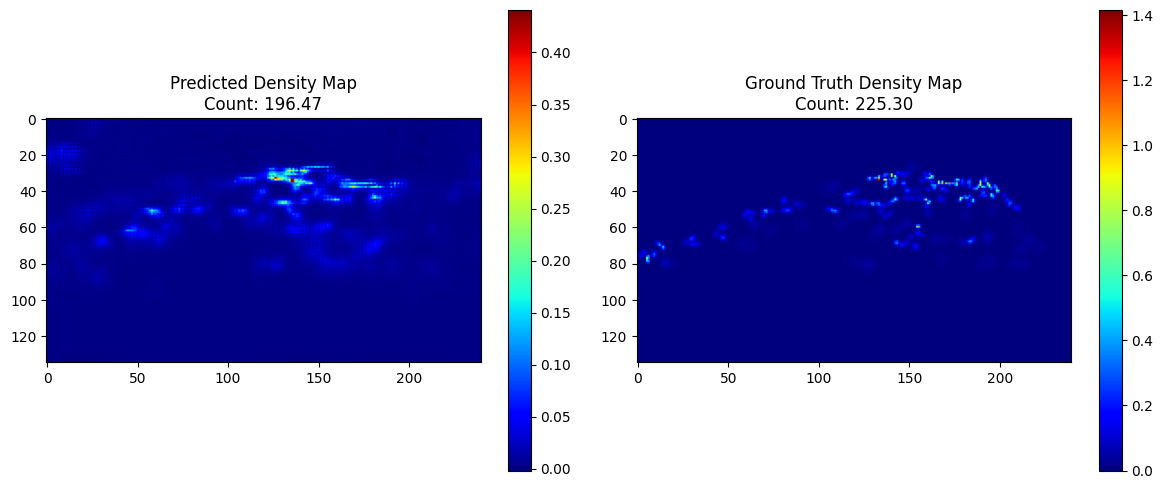

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

model.eval()

# Pick a random batch from the test loader
data_iter = iter(test_loader)
num_batches = len(test_loader)
random_batch_index = random.randint(0, num_batches - 1)

# Manually iterate to that batch
for i in range(random_batch_index + 1):
    images, targets = next(data_iter)

# Take the first image in the batch
image = images[0].unsqueeze(0).to(device)
target = targets[0].squeeze(0).cpu().numpy()

with torch.no_grad():
    prediction = model(image)

pred_map = prediction.squeeze(0).squeeze(0).cpu().numpy()
pred_count = pred_map.sum()
gt_count = target.sum()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_map, cmap='jet')
plt.title(f"Predicted Density Map\nCount: {pred_count:.2f}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(target, cmap='jet')
plt.title(f"Ground Truth Density Map\nCount: {gt_count:.2f}")
plt.colorbar()

plt.tight_layout()
plt.show()
